In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL

import vgg16

In [2]:
tf.__version__

'1.8.0'

In [3]:
vgg16.maybe_download()

Data has apparently already been downloaded and unpacked.


In [4]:
# Some helper functions

def load_image(file, size = (224,224)):
    image = PIL.Image.open(file)
    image = image.resize(size)
    return np.array(image)


def save_image(img,file_name):
    image = img.clip(0.0,255.0)
    # Converting to byte
    image = image.astype(np.uint8)
    
    with open(file_name,'wb') as write_file:
        PIL.Image.fromarray(image).save(write_file,'jpeg')


def plot_single(image, fig_size = (7,7)):
    fig = plt.figure(figsize = fig_size)
    plt.imshow(image)
    plt.axis('off')
    
def plot_images(content_image,style_image, mixed_image):
    fig = plt.figure(figsize = (15,15))
    images = [content_image,style_image,mixed_image]
    for i in range(3):
        ax = plt.subplot(1,3,i+1)
        plt.imshow(images[i], interpolation='nearest')
        plt.axis('off')

In [5]:
# Mean Squared Error

def mean_squared_error(tensor1, tensor2):
    return tf.reduce_mean(tf.square(tensor1-tensor2))

# Content Loss Function

def content_loss(sess,model,content_image, layer_id):
    feed_dict = model.create_feed_dict(image = content_image)
    layers = model.get_layer_tensors(layer_id)
    #Output from required layers
    layer_outputs = sess.run(layers,feed_dict = feed_dict) #values
    
    with model.graph.as_default():
        layer_loss = []
        
        for output,layer in zip(layer_outputs,layers):
            output_const = tf.constant(output)
            loss = mean_squared_error(layer,output_const)
            
            layer_loss.append(loss)
        total_loss = tf.reduce_mean(layer_loss)
        
    return total_loss
        

In [6]:
# Content Loss Function

def content_loss(sess,model,content_image,layer_id):
    content_feed_dict = model.create_feed_dict(image = content_image)
    layers = model.get_layer_tensors(layer_id)
    
    content_outputs = sess.run(layers,feed_dict = content_feed_dict)
    
    with model.graph.as_default():
        layer_content_loss = []
        
        for layer,content in zip(layers,content_outputs):
            content_const = tf.constant(content)
            content_loss = mean_squared_error(layer,content_const)
            
            layer_content_loss.append(content_loss)
        
        avg_content_loss = tf.reduce_mean(layer_content_loss)

    return avg_content_loss

In [7]:
#Style Loss Function

def Gram_matrix(tensor):
    matrix = tf.reshape(tensor,shape = [-1,int(tensor.get_shape()[3])])
    gram_mat = tf.matmul(tf.transpose(matrix),matrix)
    return matrix

def style_loss(sess,model,style_image,layer_id):
    style_feed_dict = model.create_feed_dict(image = style_image)
    layers = model.get_layer_tensors(layer_id)
    
    with model.graph.as_default():
        layer_style_loss = []
        gram_mat_layers = [Gram_matrix(layer) for layer in layers]
        style_outputs = sess.run(gram_mat_layers, feed_dict = style_feed_dict)
        
        for layer,style in zip(gram_mat_layers,style_outputs):
            style_const = tf.constant(style)
            style_loss = mean_squared_error(layer,style_const)

            layer_style_loss.append(style_loss)
            
        avg_style_loss = tf.reduce_mean(layer_style_loss)
    return avg_style_loss

# Syle Loss Function

def Gram_matrix(tensor):
    
    matrix = tf.reshape(tensor,shape = [-1,int(tensor.get_shape()[3])])
    gram_mat = tf.matmul(tf.transpose(matrix),matrix)
    return gram_mat

def style_loss(sess,model,style_image,layer_id):
    feed_dict = model.create_feed_dict(image = style_image)
    layers = model.get_layer_tensors(layer_id)
    
    with model.graph.as_default():
        
        layer_loss = []
        gram_mat_layers = [Gram_matrix(layer) for layer in layers]
        layer_outputs = sess.run(gram_mat_layers, feed_dict = feed_dict)
        
        for output,layer in zip(layer_outputs,gram_mat_layers):
            output_const = tf.constant(output)
            loss = mean_squared_error(output_const,layer)
            layer_loss.append(loss)
        
        total_loss = tf.reduce_mean(layer_loss)
    return total_loss

## Delete These

Running these to see if created functions are working or not

In [8]:
model = vgg16.VGG16()

In [9]:
def create_denoise_loss(model):
    loss = tf.reduce_sum(tf.abs(model.input[:,1:,:,:] - model.input[:,:-1,:,:])) + \
           tf.reduce_sum(tf.abs(model.input[:,:,1:,:] - model.input[:,:,:-1,:]))

    return loss

In [10]:
def style_transfer(content_image, style_image,
                   content_layer_ids, style_layer_ids,
                   weight_content=1.5, weight_style=10.0,
                   weight_denoise=0.3,
                   num_iterations=120, step_size=10.0):
    """
    Use gradient descent to find an image that minimizes the
    loss-functions of the content-layers and style-layers. This
    should result in a mixed-image that resembles the contours
    of the content-image, and resembles the colours and textures
    of the style-image.
    
    Parameters:
    content_image: Numpy 3-dim float-array with the content-image.
    style_image: Numpy 3-dim float-array with the style-image.
    content_layer_ids: List of integers identifying the content-layers.
    style_layer_ids: List of integers identifying the style-layers.
    weight_content: Weight for the content-loss-function.
    weight_style: Weight for the style-loss-function.
    weight_denoise: Weight for the denoising-loss-function.
    num_iterations: Number of optimization iterations to perform.
    step_size: Step-size for the gradient in each iteration.
    """

    # Create an instance of the VGG16-model. This is done
    # in each call of this function, because we will add
    # operations to the graph so it can grow very large
    # and run out of RAM if we keep using the same instance.
    model = vgg16.VGG16()

    # Create a TensorFlow-session.
    session = tf.InteractiveSession(graph=model.graph)

    # Print the names of the content-layers.
    print("Content layers:")
    print(model.get_layer_names(content_layer_ids))
    print()

    # Print the names of the style-layers.
    print("Style layers:")
    print(model.get_layer_names(style_layer_ids))
    print()

    # Create the loss-function for the content-layers and -image.
    loss_content = content_loss(session,
                                       model=model,
                                       content_image=content_image,
                                       layer_id=content_layer_ids)

    # Create the loss-function for the style-layers and -image.
    loss_style = style_loss(session,
                                   model=model,
                                   style_image=style_image,
                                   layer_id=style_layer_ids)    

    # Create the loss-function for the denoising of the mixed-image.
    loss_denoise = create_denoise_loss(model)

    # Create TensorFlow variables for adjusting the values of
    # the loss-functions. This is explained below.
    adj_content = tf.Variable(1e-10, name='adj_content')
    adj_style = tf.Variable(1e-10, name='adj_style')
    adj_denoise = tf.Variable(1e-10, name='adj_denoise')

    # Initialize the adjustment values for the loss-functions.
    session.run([adj_content.initializer,
                 adj_style.initializer,
                 adj_denoise.initializer])

    # Create TensorFlow operations for updating the adjustment values.
    # These are basically just the reciprocal values of the
    # loss-functions, with a small value 1e-10 added to avoid the
    # possibility of division by zero.
    update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
    update_adj_style = adj_style.assign(1.0 / (loss_style + 1e-10))
    update_adj_denoise = adj_denoise.assign(1.0 / (loss_denoise + 1e-10))

    # This is the weighted loss-function that we will minimize
    # below in order to generate the mixed-image.
    # Because we multiply the loss-values with their reciprocal
    # adjustment values, we can use relative weights for the
    # loss-functions that are easier to select, as they are
    # independent of the exact choice of style- and content-layers.
    loss_combined = weight_content * adj_content * loss_content + \
                    weight_style * adj_style * loss_style + \
                    weight_denoise * adj_denoise * loss_denoise

    # Use TensorFlow to get the mathematical function for the
    # gradient of the combined loss-function with regard to
    # the input image.
    gradient = tf.gradients(loss_combined, model.input)

    # List of tensors that we will run in each optimization iteration.
    run_list = [gradient, update_adj_content, update_adj_style, \
                update_adj_denoise]

    # The mixed-image is initialized with random noise.
    # It is the same size as the content-image.
    mixed_image = np.random.rand(*content_image.shape) + 128

    for i in range(num_iterations):
        # Create a feed-dict with the mixed-image.
        feed_dict = model.create_feed_dict(image=mixed_image)

        # Use TensorFlow to calculate the value of the
        # gradient, as well as updating the adjustment values.
        grad, adj_content_val, adj_style_val, adj_denoise_val \
        = session.run(run_list, feed_dict=feed_dict)

        # Reduce the dimensionality of the gradient.
        grad = np.squeeze(grad)

        # Scale the step-size according to the gradient-values.
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # Update the image by following the gradient.
        mixed_image -= grad * step_size_scaled

        # Ensure the image has valid pixel-values between 0 and 255.
        mixed_image = np.clip(mixed_image, 0.0, 255.0)

        # Print a little progress-indicator.
        print(". ", end="")

        # Display status once every 10 iterations, and the last.
        if (i % 10 == 0) or (i == num_iterations - 1):
            print()
            print("Iteration:", i)

            # Print adjustment weights for loss-functions.
            msg = "Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2:.2e}"
            print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))

            # Plot the content-, style- and mixed-images.
            plot_images(content_image=content_image,
                        style_image=style_image,
                        mixed_image=mixed_image)
            
    print()
    print("Final image:")
    plot_single(mixed_image)

    # Close the TensorFlow session to release its resources.
    session.close()
    
    # Return the mixed-image.
    return mixed_image

In [11]:
content_filename = '../../../Tensorflow/TensorFlow-Tutorials/images/willy_wonka_old.jpg'
content_image = load_image(content_filename)

In [12]:
style_filename = '../../../Tensorflow/TensorFlow-Tutorials/images/style2.jpg'
style_image = load_image(style_filename)

In [13]:
content_layer_ids = [4]

In [14]:
# The VGG16-model has 13 convolutional layers.
# This selects all those layers as the style-layers.
# This is somewhat slow to optimize.
style_layer_ids = list(range(13))

# You can also select a sub-set of the layers, e.g. like this:
# style_layer_ids = [1, 2, 3, 4]

Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


. 
Iteration: 0
Weight Adj. for Content: 4.30e-11, Style: 4.49e-11, Denoise: 1.00e-05
. . . . . . . . . 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


. 
Iteration: 10
Weight Adj. for Content: 1.98e-11, Style: 2.40e-10, Denoise: 1.22e-07
. . . . 

KeyboardInterrupt: 

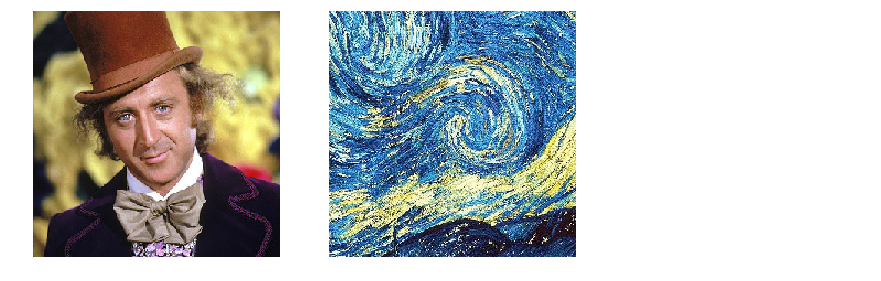

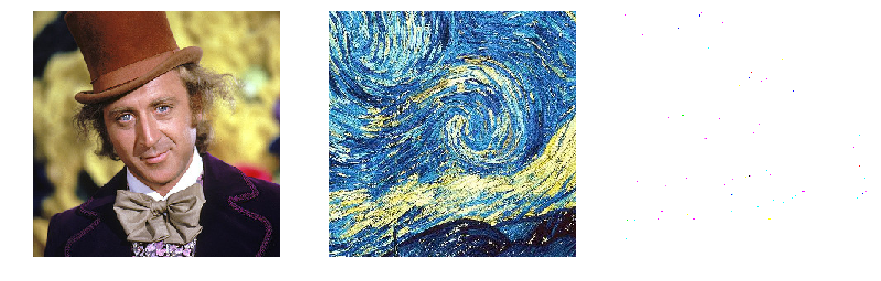

In [15]:
%%time
img = style_transfer(content_image=content_image,
                     style_image=style_image,
                     content_layer_ids=content_layer_ids,
                     style_layer_ids=style_layer_ids,
                     weight_content=1.5,
                     weight_style=10.0,
                     weight_denoise=0.3,
                     num_iterations=60,
                     step_size=10.0)